<a href="https://colab.research.google.com/github/Eduarda-Donato/sentiment-analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from tqdm.notebook import tqdm
from imblearn.under_sampling import RandomUnderSampler

import torch
from torch import nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from transformers import DataCollatorWithPadding
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer

ds = load_dataset("AbrilCota/moviesData")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


rotten_tomatoes_movie_reviews.csv:   0%|          | 0.00/411M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1444963 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'reviewId', 'creationDate', 'criticName', 'isTopCritic', 'originalScore', 'reviewState', 'publicatioName', 'reviewText', 'scoreSentiment', 'reviewUrl'],
        num_rows: 1444963
    })
})

In [4]:
ds['train'] = ds['train'].select_columns(['reviewText','scoreSentiment'])
ds = ds.rename_column('scoreSentiment','labels')
ds

DatasetDict({
    train: Dataset({
        features: ['reviewText', 'labels'],
        num_rows: 1444963
    })
})

In [5]:
def replace_label(row):
  row['labels'] = 1 if row['labels'] == "POSITIVE" else 0
  return row

In [6]:
ds = ds.map(replace_label)

Map:   0%|          | 0/1444963 [00:00<?, ? examples/s]

In [7]:
split = ds['train'].train_test_split(test_size=0.2, shuffle=True, seed=42)

ds_train = split['train']
ds_test = split['test']

In [8]:
split2 = ds_train.train_test_split(
    test_size=0.2,
    shuffle=True,
    seed=42
)

ds_train = split2['train']
ds_val = split2['test']

In [9]:
ds_train_small = ds_train.shuffle(seed=42).select(range(200000))
ds_val_small = ds_val.shuffle(seed=42).select(range(100000))
ds_test_small = ds_test.shuffle(seed=42).select(range(100000))

In [10]:
counts = Counter(ds_train_small['labels'])
print(counts)


Counter({1: 133632, 0: 66368})


In [11]:
def undersample(dataset, label_col="labels", seed=42):
    labels = np.array(dataset[label_col])

    class0_idx = np.where(labels == 0)[0]
    class1_idx = np.where(labels == 1)[0]

    min_count = min(len(class0_idx), len(class1_idx))

    np.random.seed(seed)
    class0_sample = np.random.choice(class0_idx, min_count, replace=False)
    class1_sample = np.random.choice(class1_idx, min_count, replace=False)

    balanced_idx = np.concatenate([class0_sample, class1_sample])
    np.random.shuffle(balanced_idx)

    balanced_dataset = dataset.select(balanced_idx.tolist())

    return balanced_dataset


In [12]:
ds_train_balanced = undersample(ds_train_small)

In [13]:
counts = Counter(ds_train_balanced['labels'])
print(counts)

Counter({0: 66368, 1: 66368})


In [14]:
def tokenization(batch):
  texts = [t if t is not None else "" for t in batch["reviewText"]]
  return tokenizer(
      texts,
      truncation=True,
      padding=False,
      max_length=256)

In [15]:
ds_train_balanced = ds_train_balanced.map(tokenization, batched=True)
ds_val_small = ds_val_small.map(tokenization, batched=True)
ds_test_small = ds_test_small.map(tokenization, batched=True)

Map:   0%|          | 0/132736 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [16]:
ds_train

Dataset({
    features: ['reviewText', 'labels'],
    num_rows: 924776
})

In [17]:
ds_train_balanced = ds_train_balanced.remove_columns(['reviewText', 'token_type_ids'])
ds_val_small = ds_val_small.remove_columns(['reviewText', 'token_type_ids'])
ds_test_small = ds_test_small.remove_columns(['reviewText', 'token_type_ids'])


In [18]:
'''
tokens_counts = Counter()

for ids in ds_train['input_ids']:
  tokens_counts.update(ids)

top_ids = tokens_counts.most_common(10)

top_ids

[(tokenizer.convert_ids_to_tokens(id), count) for id, count in top_ids]
'''

"\ntokens_counts = Counter()\n\nfor ids in ds_train['input_ids']:\n  tokens_counts.update(ids)\n\ntop_ids = tokens_counts.most_common(10)\n\ntop_ids\n\n[(tokenizer.convert_ids_to_tokens(id), count) for id, count in top_ids]\n"

In [19]:
ds_train_balanced.set_format(type="torch", columns=['input_ids', 'attention_mask','labels'])
ds_val_small.set_format(type="torch", columns=['input_ids', 'attention_mask', 'labels'])
ds_test_small.set_format(type="torch", columns=['input_ids', 'attention_mask', 'labels'])

In [20]:
ds_train

Dataset({
    features: ['reviewText', 'labels'],
    num_rows: 924776
})

In [21]:
BATCH_SIZE = 32
collator = DataCollatorWithPadding(tokenizer)

In [22]:
dataloader_train = DataLoader(
    ds_train_balanced,
    batch_size=BATCH_SIZE,
    collate_fn=collator,
    #sampler=sampler,
    shuffle=True
  )
dataloader_val = DataLoader(
    ds_val_small,
    batch_size=BATCH_SIZE,
    collate_fn=collator,
    shuffle=True
  )
dataloader_test = DataLoader(
    ds_test_small,
    batch_size=BATCH_SIZE,
    collate_fn=collator,
    shuffle=True
  )

In [23]:
EMBED_DIM = 128
HIDDEN_DIM = 32
N_LAYERS = 1

class TextClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.embedding_layer = nn.Embedding(
        num_embeddings=len(tokenizer),
        embedding_dim=EMBED_DIM
    )
    self.rnn = nn.RNN(
        input_size=EMBED_DIM,
        hidden_size=HIDDEN_DIM,
        num_layers=N_LAYERS,
        batch_first=True
        )
    self.linear = nn.Linear(
        in_features= HIDDEN_DIM,
        out_features=1
        )

  def forward(self, input, attention_mask):                   # input → (batch, seq_len) [seq_len = number of tokens per batch (after padding)]
    embeddings = self.embedding_layer(input)                  # (batch, seq_len, EMBED_DIM)

    lengths = attention_mask.sum(dim=1).cpu()

    packed = pack_padded_sequence(
        embeddings,
        lengths,
        batch_first=True,
        enforce_sorted=False
    )

    output, final_hidden = self.rnn(packed)                   # (batch, seq_len, hidden) , (num_layers, batch, hidden)
    #final_hidden = final_hidden.squeeze(0)                   # (batch, hidden)
    return self.linear(final_hidden[-1])

In [24]:
device = torch.device('cuda')

model = TextClassifier()
model = model.to(device)

In [25]:
LR = 1e-3
EPOCHS = 5
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [26]:
def train(dataloader, device):
  model.train()

  size = len(dataloader.dataset)
  train_losses = []

  for batch in tqdm(dataloader):
    data = batch['input_ids'].to(device)
    mask = batch['attention_mask'].to(device)
    label = batch['labels'].float().to(device)

    out = model(data, mask).squeeze(1)
    loss = loss_fn(out, label)

    train_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  avg_loss = sum(train_losses)/len(train_losses)

  return avg_loss




In [27]:
def val(dataloader, device):
  model.eval()

  size = len(dataloader.dataset)
  val_losses = []
  correct = 0

  with torch.no_grad():
    for batch in tqdm(dataloader):
      data = batch['input_ids'].to(device)
      mask = batch['attention_mask'].to(device)
      label = batch['labels'].float().to(device)

      out = model(data, mask).squeeze(1)

      loss = loss_fn(out, label)
      val_losses.append(loss.item())

      probs = torch.sigmoid(out)
      preds = (probs > 0.5).float()
      correct += (preds == label).sum().item()

    acc = correct / size
    avg_loss = sum(val_losses)/len(val_losses)

    return avg_loss, acc

In [28]:
def test(dataloader, device):
  model.eval()

  size = len(dataloader.dataset)
  correct = 0
  losses = []

  with torch.no_grad():
    for batch in dataloader:
      data = batch['input_ids'].to(device)
      mask = batch['attention_mask'].to(device)
      label = batch['labels'].float().to(device)

      out = model(data, mask).squeeze(1)

      loss = loss_fn(out, label)
      losses.append(loss.item())

      probs = torch.sigmoid(out)
      preds = (probs > 0.5).float()
      correct += (preds == label).sum().item()

  acc = correct / size
  avg_loss = sum(losses)/len(losses)

  print(f"test accuracy: {acc*100:.1f}% | test loss: {avg_loss:.4f}")





In [29]:
history = {
    'train_loss': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0

for epoch in range(EPOCHS):

  train_loss = train(dataloader_train, device)
  history['train_loss'].append(train_loss)

  val_loss, acc_val = val(dataloader_val, device)
  history['val_loss'].append(val_loss)
  history['val_acc'].append(acc_val)

  print(
        f"Epoch {epoch:03d} | "
        f"Train loss: {train_loss:.4f} | "
        f"Val loss: {val_loss:.4f} | "
        f"Val acc: {acc_val:.4f}"
    )

  if acc_val > best_val_acc:
      best_val_acc = acc_val
      torch.save(model.state_dict(), f'best_model_epoch_{epoch+1}.pt')
      print(f"Model saved: best_model_epoch_{epoch+1}.pt with validation accuracy: {acc_val:.4f}")

  0%|          | 0/4148 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 000 | Train loss: 0.6151 | Val loss: 0.5378 | Val acc: 0.7174
Model saved: best_model_epoch_1.pt with validation accuracy: 0.7174


  0%|          | 0/4148 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 001 | Train loss: 0.5075 | Val loss: 0.5243 | Val acc: 0.7367
Model saved: best_model_epoch_2.pt with validation accuracy: 0.7367


  0%|          | 0/4148 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 002 | Train loss: 0.4641 | Val loss: 0.5190 | Val acc: 0.7456
Model saved: best_model_epoch_3.pt with validation accuracy: 0.7456


  0%|          | 0/4148 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 003 | Train loss: 0.4329 | Val loss: 0.4909 | Val acc: 0.7505
Model saved: best_model_epoch_4.pt with validation accuracy: 0.7505


  0%|          | 0/4148 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 004 | Train loss: 0.4070 | Val loss: 0.4925 | Val acc: 0.7573
Model saved: best_model_epoch_5.pt with validation accuracy: 0.7573


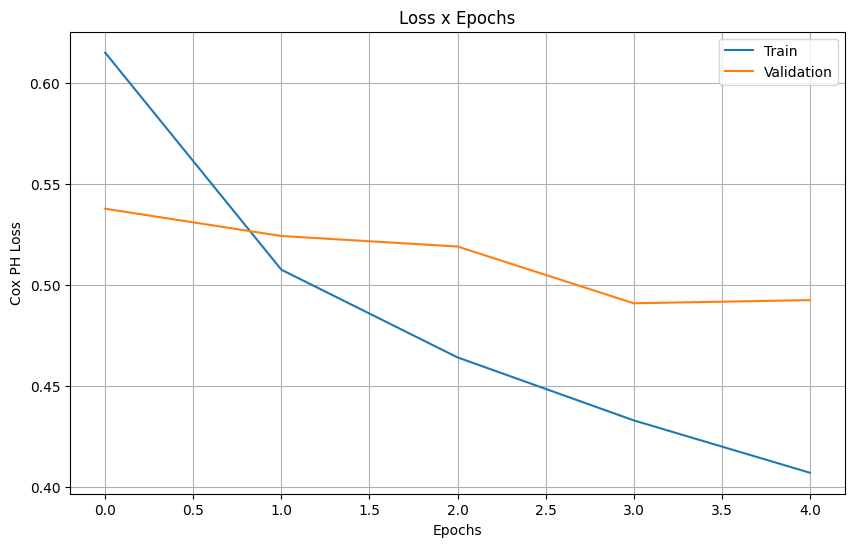

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss x Epochs')
plt.xlabel('Epochs')
plt.ylabel('Cox PH Loss')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
test(dataloader_test, device)

test accuracy: 75.5% | test loss: 0.4953


In [32]:
example_texts = [
    "This movie was absolutely fantastic! I loved every minute of it.",
    "It was a complete waste of time. I wouldn't recommend it to anyone.",
    "The acting was fantastic, and the plot was nice.",
    "Absolutely horrible experience, never again."
]

encoded_inputs = tokenizer(
    example_texts,
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors="pt"
)

input_ids = encoded_inputs['input_ids'].to(device)
attention_mask = encoded_inputs['attention_mask'].to(device)

model.eval()
with torch.no_grad():
    outputs = model(input_ids, attention_mask).squeeze(1)
    probabilities = torch.sigmoid(outputs)
    predictions = (probabilities > 0.5).long()

for i, text in enumerate(example_texts):
    sentiment = "POSITIVE" if predictions[i].item() == 1 else "NEGATIVE"
    print(f"Review: '{text}'")
    print(f"Predicted Sentiment: {sentiment} (Probability: {probabilities[i].item():.4f})\n")

Review: 'This movie was absolutely fantastic! I loved every minute of it.'
Predicted Sentiment: POSITIVE (Probability: 0.8170)

Review: 'It was a complete waste of time. I wouldn't recommend it to anyone.'
Predicted Sentiment: NEGATIVE (Probability: 0.0902)

Review: 'The acting was fantastic, and the plot was nice.'
Predicted Sentiment: POSITIVE (Probability: 0.6424)

Review: 'Absolutely horrible experience, never again.'
Predicted Sentiment: NEGATIVE (Probability: 0.2038)

